In [1]:
import numpy as np
import scipy.constants as const
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import math
from scipy.integrate import quad
import pandas as pd
import config

In [2]:
userHome = config.userHome()
outdir = userHome + "/projects/cs/data/raw/ext/n2/itikawa/"

In [3]:
pi = const.pi
e = const.e
e0= const.epsilon_0

In [4]:
eV_per_J = const.physical_constants["joule-electron volt relationship"][0]
cm_per_m = 100.0

In [5]:
def Gv(v, we, wexe, weye, weze=0, weae=0):
    return we*(v+1/2) - wexe*(v+1/2)**2 + weye*(v+1/2)**3 + weze*(v+1/2)**4 + weae*(v+1/2)**5

def Te(v, T0, we, wexe, weye, weze=0, weae=0):
    return T0 - we/2 + wexe/4 - weye/8 - weze/16 - weae/32

def Tv(v, T0, we, wexe, weye, weze=0, weae=0):
    return Te(v, T0, we, wexe, weye, weze, weae) + Gv(v, we, wexe, weye, weze, weae)

def Bv(v, Be, ae, ge=0, de=0, ee=0):
    return Be - ae*(v+1/2) - ge*(v+1/2)**2 + de*(v+1/2)**3 + ee*(v+1/2)**4

def fIntegrand(vp, v, vibConstants):
    (T0, we, wexe, weye, weze, weae) = vibConstants
    return 1/math.sqrt(Gv(v,we,wexe,weye,weze)-Gv(vp,we,wexe,weye,weze))

def gIntegrand(vp, v, vibConstants, rotConstants):
    (T0, we, wexe, weye, weze, weae) = vibConstants
    (Be, ae, ge, de, ee) = rotConstants
    return Bv(v,Be,ae,ge)/math.sqrt(Gv(v,we,wexe,weye,weze)-Gv(vp,we,wexe,weye,weze))

In [6]:
statesN2 = ["N2(X1Sigmag+)","N2(A3Sigmau+)","N2(B3Pig)","N2(W3Deltau)","N2(Bp3Sigmau-)",
            "N2(ap1Sigmau-)","N2(a1Pig)","N2(w1Deltau)","N2(C3Piu)","N2(E3Sigmag+)","N2(D3Sigmau+)"]
statesN2p = ["N2+(X2Sigmag+)","N2+(A2Piu)","N2+(B2Sigmau+)","N2+(C2Sigmau+)"]

vibConstantsN2 = [[0.0, 2358.57, 14.324, -2.26E-3, -2.4E-4, 0],
                 [49754.8, 1460.48, 13.775, -1.175E-2, 1.41E-4, -7.29E-5],
                 [59306.8, 1734.38, 14.558, 1.40E-2, -1.13E-3, 0],
                 [59380.2, 1506.53, 12.575, 3.09E-2, -7.1E-4, 0],
                 [65851.3, 1516.88, 12.181, 4.19E-2, -7.3E-4, 0],
                 [67739.3, 1530.25, 12.075, 4.13E-2, -2.9E-4, 0],
                 [68951.2, 1694.21, 13.949, 7.94E-3, 2.9E-4, 0],
                 [71698.4, 1559.50, 12.008, 4.54E-2, 0, 0],
                 [88977.9, 2047.18, 28.445, 2.0883, -5.350E-1, 0],
                 [95774.5, 2218, 16.3, -2.7E-2, -2.6E-3, 0],
                 [103570.9, 2207, 16.3, -2.7E-2, -2.6E-3, 0]]

vibConstantsN2p = [[125667.5, 2207.37, 16.302, -2.67E-3, -2.61E-3, 3.7E-5],
                  [134683.1, 1903.51, 15.029, 2.03E-3, 0, 0],
                  [151233.5, 2420.83, 23.851, -0.3587, -6.192E-2, 0],
                  [190209.5, 2071.5, 9.29, -0.43, 0, 0]]

rotConstantsN2 = [[1.99824, 1.7318E-2, -3.3E-5, 0, 0],
                 [1.45499, 1.8385E-2, 1.24E-5, -6.7E-6, 0],
                 [1.63802, 1.8302E-2, -8.4E-6, -3.4E-6, 0],
                 [1.47021, 1.6997E-2, -1.01E-5, 3.3E-7, 0],
                 [1.4731, 1.668E-2, 1.84E-5, -4.5E-7, 0],
                 [1.4799, 1.657E-2, 2.41E-5, 0, 0],
                 [1.6169, 1.793E-2, -2.93E-5, 0, 0],
                 [1.4963, 1.63E-2, 0, 0, 0],
                 [1.8247, 1.868E-2, -2.28E-3, 7.33E-4, -1.5E-4],
                 [1.9368, 1.90E-2, -1.9E-4, 0, 0],
                 [1.9705, 1.90E-2, -1.9E-4, 0, 0]]

rotConstantsN2p = [[1.93177, 1.900E-2, -1.91E-5, -5.00E-6, 4.6E-8],
                  [1.7442, 1.838E-2, -1.76E-4, 4.4E-6, 0],
                  [2.0845, 2.132E-2, -8.5E-4, 0, 0],
                  [1.5114, 1.10E-3, -8.2E-4, 0, 0]]

In [7]:
mu=1.16294E-26
wavenumber_per_eV = 8065.6

In [8]:
def f(v, vibConstants):
    I = quad(fIntegrand,-1/2,v,args=(v, vibConstants))
    return 1/(2*const.pi*math.sqrt(2*mu*const.speed_of_light/const.Planck)) * I[0] * 1E8

def g(v, vibConstants, rotConstants):
    I = quad(gIntegrand,-1/2,v,args=(v, vibConstants, rotConstants))
    return 2*const.pi*math.sqrt(2*mu*const.speed_of_light/const.Planck) * I[0] * 1E-8

In [9]:
def r(v, vibConstants, rotConstants):
    fv=f(v, vibConstants)
    gv=g(v, vibConstants, rotConstants)
    return [math.sqrt(fv**2 + fv/gv)-fv, math.sqrt(fv**2 + fv/gv)+fv]

In [10]:
def Jv(vMaxN2, vMaxN2p, stateN2, stateN2p):

    N2pPES = []
    (T0, we, wexe, weye, weze, weae) = vibConstantsN2p[stateN2p]

    for vp in range(vMaxN2p+1):
        rvp=r(vp, vibConstantsN2p[stateN2p], rotConstantsN2p[stateN2p])
        Tvp=Tv(vp, T0, we, wexe, weye, weze, weae)/wavenumber_per_eV
        N2pPES.insert(0, [rvp[0], Tvp])
        N2pPES.append([rvp[1], Tvp])
    
    N2pPES = np.asarray(N2pPES)
    
    I_N2pPES = interpolate.interp1d(N2pPES[:,0], N2pPES[:,1], kind='quadratic')

    N2PES = []
    JvArray = np.empty([vMaxN2+1,2])
        
    (T0, we, wexe, weye, weze, weae) = vibConstantsN2[stateN2]
    for v in range(len(JvArray)):
        rv=r(v, vibConstantsN2[stateN2], rotConstantsN2[stateN2])
        Tvv=Tv(v, T0, we, wexe, weye, weze, weae)/wavenumber_per_eV
        N2PES.insert(0, [rv[0], Tvv])
        N2PES.append([rv[1], Tvv])
        JvArray[v] = I_N2pPES(rv)-Tvv

    N2PES = np.asarray(N2PES)
        
    return (N2PES, N2pPES, JvArray)

In [11]:
(N2PES, N2pPES, Jvv) = Jv(40,35,0,0)

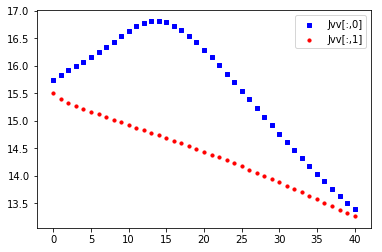

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = list(range(len(Jvv)))
y = Jvv[:,0]
ax1.scatter(x, y, s=10, c='b', marker="s", label='Jvv[:,0]')
y = Jvv[:,1]
ax1.scatter(x,y, s=10, c='r', marker="o", label='Jvv[:,1]')
plt.legend(loc='upper right');
plt.show()

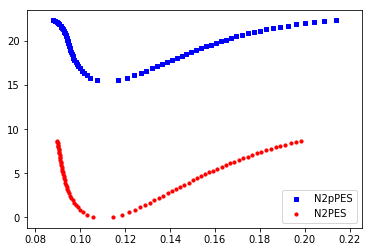

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x,y = N2pPES.T
ax1.scatter(x, y, s=10, c='b', marker="s", label='N2pPES')
x,y = N2PES.T
ax1.scatter(x,y, s=10, c='r', marker="o", label='N2PES')
plt.legend(loc='lower right');
plt.show()

In [14]:
def f_eqn15(x: float):
    "Equation 15 of Kosarim, et al., for all electrons."
    "return (6*(x-1))/(pi*(x+1.5)*(x+9))"
    return (6*(x-1))/(pi*(x+10)*(x+2))

In [15]:
def sigma_ion(f, n: int, E: float, J_v_vp: float, J_v_vpp: float):
    """Compute cross-sections (10^-17 cm^2) of ionization transitions for 
    Tables 2-4 of Kosarim, et al."""
    return (cm_per_m**2 * eV_per_J**2)/(1.0E-17)  * (1./(4.*pi*e0)**2) * \
        ((n*e**4)/2.) * ( f(E/J_v_vp)/(J_v_vp**2) + f(E/J_v_vpp)/(J_v_vpp**2) )

In [35]:
datafiles = [outdir+"ionization_N2+_itikawa2006_15",
             outdir+"ionization_N2+_itikawa2006_16",
             outdir+"ionization_N2+_itikawa2006_17"]
sigma_total=[]

for datafile in datafiles:
    df = pd.read_csv(datafile, sep="\t")   # read .tsv file into memory
    sigma_total.append(df.values[:,[1,2]])  # access the numpy array containing values

sigma_total=np.concatenate((sigma_total[0],
                            sigma_total[1],
                            sigma_total[2]), axis=0)

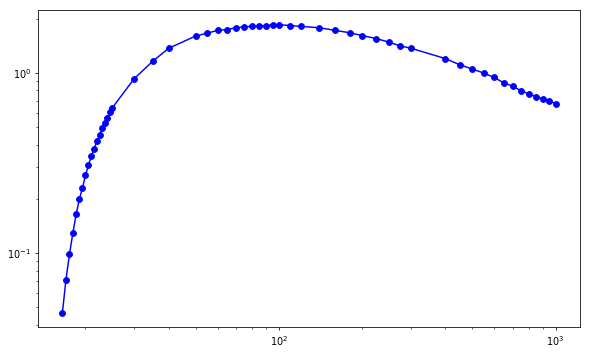

In [42]:
w = 10
h = 6
d = 70
plt.figure(figsize=(w, h), dpi=d)

x=sigma_total[:,0]
y=sigma_total[:,1]

plt.loglog(x, y, c='b', marker="o")

In [17]:
vMat=np.repeat(np.array([np.arange(len(Jvv))]),len(Jvv),axis=0).T
EMat=np.repeat(np.array([np.logspace(1.3, 2.3, num=len(Jvv))]),len(Jvv),axis=0)
sigma = np.empty([len(Jvv), len(EMat[0])])
for v in vMat[:,0]:
    sigma[v] = sigma_ion(f_eqn15, 2, EMat[0], Jvv[v,0], Jvv[v,1])


In [18]:
vMat[:,0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40])

In [19]:
EMat[0]

array([ 19.95262315,  21.1348904 ,  22.38721139,  23.71373706,
        25.11886432,  26.6072506 ,  28.18382931,  29.85382619,
        31.6227766 ,  33.49654392,  35.48133892,  37.58374043,
        39.81071706,  42.16965034,  44.66835922,  47.3151259 ,
        50.11872336,  53.08844442,  56.23413252,  59.56621435,
        63.09573445,  66.83439176,  70.79457844,  74.98942093,
        79.43282347,  84.13951416,  89.12509381,  94.40608763,
       100.        , 105.92537252, 112.20184543, 118.85022274,
       125.89254118, 133.35214322, 141.25375446, 149.62356561,
       158.48931925, 167.88040181, 177.827941  , 188.36490895,
       199.5262315 ])

In [20]:
sigma[0]

array([0.24420484, 0.30170003, 0.35894752, 0.41578779, 0.47205745,
       0.52759033, 0.58221856, 0.63577378, 0.6880884 , 0.73899684,
       0.78833681, 0.83595067, 0.88168662, 0.92540001, 0.96695451,
       1.00622326, 1.0430899 , 1.07744957, 1.10920971, 1.13829086,
       1.16462722, 1.18816716, 1.20887355, 1.22672393, 1.24171061,
       1.25384056, 1.26313516, 1.26962982, 1.27337356, 1.2744283 ,
       1.27286817, 1.26877868, 1.26225577, 1.25340487, 1.24233976,
       1.22918153, 1.21405741, 1.19709963, 1.17844421, 1.1582299 ,
       1.13659698])

In [21]:
sigma[40]

array([0.55138219, 0.62884097, 0.70534548, 0.78066572, 0.85457058,
       0.92682958, 0.99721456, 1.06550145, 1.13147209, 1.19491594,
       1.25563182, 1.3134296 , 1.36813174, 1.41957481, 1.46761078,
       1.5121083 , 1.55295373, 1.59005199, 1.62332732, 1.65272374,
       1.67820541, 1.69975672, 1.71738225, 1.73110645, 1.74097321,
       1.74704523, 1.74940319, 1.74814478, 1.74338362, 1.73524796,
       1.72387942, 1.70943149, 1.69206803, 1.67196175, 1.6492926 ,
       1.62424617, 1.59701214, 1.56778268, 1.53675101, 1.50410988,
       1.47005029])

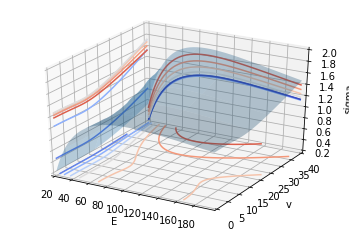

In [22]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
X=EMat
Y=vMat
Z=sigma

# Plot the 3D surface
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)

# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph
cset = ax.contour(X, Y, Z, zdir='z', offset=0.2, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=min(X[0]), cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=max(Y[:,0]), cmap=cm.coolwarm)

ax.set_xlim(min(X[0]),max(X[0]))
ax.set_ylim(min(Y[:,0]),max(Y[:,0]))
ax.set_zlim(0.2,2.0)

ax.set_xlabel('E')
ax.set_ylabel('v')
ax.set_zlabel('sigma')

plt.show()

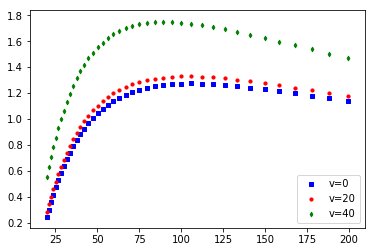

In [23]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x=EMat[0]
y=sigma[0]
ax1.scatter(x, y, s=10, c='b', marker="s", label='v=0')
y=sigma[20]
ax1.scatter(x,y, s=10, c='r', marker="o", label='v=20')
y=sigma[40]
ax1.scatter(x,y, s=10, c='g', marker="d", label='v=40')
plt.legend(loc='lower right');
plt.show()

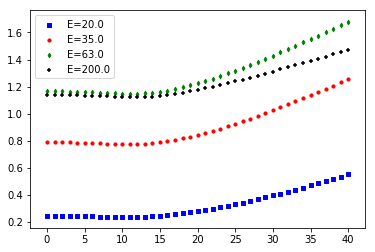

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x=vMat[:,0]
y=sigma[:,0]
ax1.scatter(x, y, s=10, c='b', marker="s", label='E='+str(round(EMat[0,0])))
y=sigma[:,10]
ax1.scatter(x,y, s=10, c='r', marker="o", label='E='+str(round(EMat[0,10])))
y=sigma[:,20]
ax1.scatter(x,y, s=10, c='g', marker="d", label='E='+str(round(EMat[0,20])))
y=sigma[:,40]
ax1.scatter(x,y, s=10, c='black', marker="+", label='E='+str(round(EMat[0,40])))
plt.legend(loc='upper left');
plt.show()